## Which type of flower is it? 
The goal for this assignment to is to classify different flowers species from a dataset(insert link) using a CNN network. Since we need to be smart in saving computing power to run on my own machine i am implementing transfer learning. The dataset we are using is fairly balanced. 
My solution will be inspired by AlexNet structure. However the goal is making a much smaller (if possible) variant on this. 

I will investigate and design the AlexNet but as an dilutad convulutation to save computation and memory speed. I am thinking of to might do the dilutation just in the beginning (since it acts as segmentation of shapes that i want to pass through the layer as early as possible to fast learn the kontur). I hope it will catch the pictures where it is over "fields" of flowers and can easier identiyfy these things   

* Dilated Convolutional Layers Early On:
Use dilated convolutions in the initial layers of the network. This helps in capturing a broader context and larger receptive fields without significantly increasing the number of parameters. It can be particularly useful for understanding global structures in the input data.
* Pooling Layers Later On:
As the network progresses, introduce pooling layers to downsample the spatial dimensions. This reduces the computational load and allows the network to focus on the most important features, helping to create a more abstract and condensed representation.


We want to do feature extraction due to small dataset to try to transfer the learning to hopefully get a better result
We can import using tf.keras.applications another ML model (check documentation)

# Step 1 Dataset. (Before and after images of dataset)
Removed some images that where not even pictures of the flowers and some pictures whre the same in both maps...
This is important since we are not working with a huge dataset and every picture needs to be good quality (altough i am not removing pictures that can be challenging, that is something else, only where it was plain wrong that it wasn't pictures of flowers or wrong flowers sort. ). My philosophy is: If me as a human can't classify each image (trying to remind myself that each image is unique, and i have prior information what it is), i am not expecting my network to learn it either. Removed images where there are multiple flowers types overlapping, removed pictures that are too far away, removed pictures where the flower hasn't fully developed or withered flowers

Dandelion can be challenging because it is essentaltity two classes into one (since the flower changes so much) and it is slightly skewed since there is more pictures on when its not blooming than yello ones. There was some mixed images as well for instance a daisy in dandelion folder

## Dataset size before:
* daisy = 764
* dandelion = 1051
* rose = 784
* sunflower = 733
* tulip = 984 

## Dataset size after:
* daisy = 742
* dandelion = 1016
* rose = 759
* sunflower = 694
* tulip = 853

Total images removed = 252

* inte fanns någon blomma i
* blommor som var av fel sort i fel mapp
* blommor som var otroligt inzoomade
* blommor som speglades genom något
* blommor som var bilder på målade blommor (behöll några riktigt realistiska)
* bilder tagna från alldeles för långt ifrån där jag som människa inte kan se vad det är (tulpanerna kan man ju gissa men det är ju för jag sitter med kunskap att det är ett tulpanfält innan, så tog bort dem)
* bilder med flera olika sorters blommor i samma bild
* vissna blommor



TODO: Maybe add a Negative Dataset 

In [1]:
# Roadmap
# TODO: Go through the each datasets and remove the images that are bad. Doccument this
# TODO: Read in images (Pillow? OpenCV)
    # class preprocessing (Would be cool)
        # __init__()
        # def process_images
            # - resize images (227x227) was 320x240 (no uniform proportion)
        # def split_dataset

# TODO: Resize the images to ensure all images are the same size in a function
# TODO: Create labels for each class (5)
# TODO: Divide them into train and test split (random seed) 
# TODO: Load in the model that will be used
    # def build_model   
# TODO: Create the different layers (pooling, how many layers)
    # rembembert that it is rgb images so it has to be 3D deep for instance 32x32x3
# TODO: --> Output is 5 classes (neurons) in the last layer
# TODO: Implement transfer learning for the model 
# TODO: Train and evalutate the model
# TODO: Fine-tuning hyperparameters?
# TODO: Visualize the training and results




In [1]:
# Importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
import PIL
from pathlib import Path
import pandas as pd
import random as rand
import scipy
# %load_ext tensorboard

import os
import visualkeras

from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


import tensorflow as tf
from keras.optimizers import Adam

from keras.models import Sequential # This is used to initialize the neural network TODO: Double check
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation # This is used to build the layers of the neural network


from keras.preprocessing.image import ImageDataGenerator

2023-12-16 19:48:06.760154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5080 files belonging to 5 classes.
Using 4064 files for training.
Found 5080 files belonging to 5 classes.
Using 1016 files for validation.
After splitting validation once more:
val_split contains: 4 objects (approx 512 images) for validation
test_split contains: 4 objects (approx 512 images) for testing
Classes in the dataset are: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Dimensions for each image batch is: (128, 227, 227, 3)
Label batch size corresponding to each object: (128,)


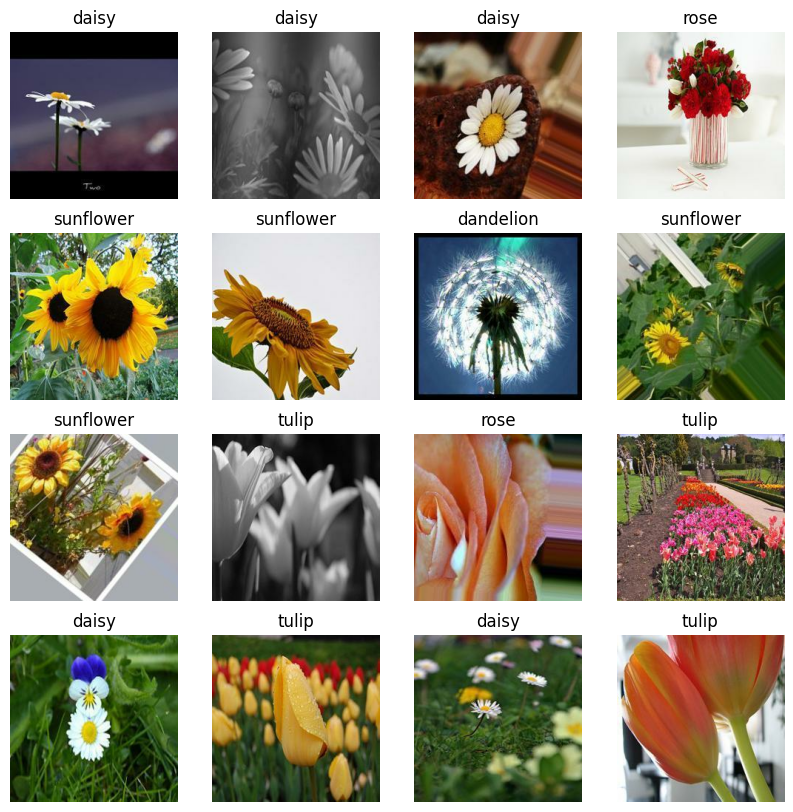

In [2]:
DATA_DIR = Path('../dl-assignment/data/flowers').with_suffix('')
WEIGHTS_PATH = Path('../dl-assignment/weights') # Path to the weights (For transfer learning)
CHECKPOINT_PATH = Path('../dl-assignment/weights/')

IMG_HEIGHT = 227 
IMG_WIDTH = 227
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2 # 20% of the data is used for validation (10 % will go to testing)
RANDOM_SEED = 137
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Network parameters (Hyper)
LEARNING_RATE = 0.01
NUM_EPOCHS = 80


NUM_CLASSES = 5 # 5 classes in the dataset
# DROPOUT_RATE = 0.5 # How many neurons to drop in each layer

def get_separator():
    """ Returns a separator """
    print("======================================================")

def count_files(DATA_DIR):
    """
    Counts the number of files in DATA_DIR's subfolders
    
    returns: 
    - highest_file: The subdir the class that has the highest number of files. (Augment other classes to match "dandelion")
    - A dictionary with the subfolder name as key and the number of files as value

    """

    highest_file = 0
    subdir_file_counts = {}

    for item in os.listdir(DATA_DIR):
        path = os.path.join(DATA_DIR, item)
        if os.path.isdir(path):
            file_count = len(os.listdir(path))
            highest_file = max(highest_file, file_count)
            subdir_file_counts[item] = file_count
            # print(f'Amount of images in each class {highest_file}')

    return highest_file, subdir_file_counts

highest_file, subdir_file_counts = count_files(DATA_DIR)

# ORIGINAL FILE COUNTS
# # daisy: 743 files
# # rose: 760 files
# # tulip: 854 files
# # dandelion: 1017 files <--- This is the highest
# # sunflower: 695 files


def augment_settings():
    """
    Settings for the augmentation using ImageDataGenerator

    """

    DATAGEN = ImageDataGenerator(
        rotation_range=45,  # rotates the images
        width_shift_range=0.2, # shifts the pixels of images so it is not centered
        height_shift_range=0.2,
        horizontal_flip=True,  # Spins the images
        vertical_flip=True,
        fill_mode='nearest', # "padds the images with the nearest pixel" -> abcd becomes aaa|abcd|ddd
    )

    return DATAGEN
    
DATAGEN = augment_settings()


def augment_images_subdir(DATA_DIR, DATAGEN, highest_file, subdir_file_counts):
    """ 
    Perform augmentation on the images in subdirs 'DATA_DIR/flower/ until generated_files is equal to the highest_file
    
    """
    for subdir, file_count in subdir_file_counts.items():
        amount_to_generate = highest_file - file_count # The amount of images to generate

        if amount_to_generate > 0:
            path_sub = os.path.join(DATA_DIR, subdir)

            # iterating over each subdir and augmenting the images
            generate_data = DATAGEN.flow_from_directory(
                DATA_DIR,
                classes=[subdir],
                target_size=(IMG_HEIGHT, IMG_WIDTH),
                batch_size=1, # one image at a time
                save_to_dir=path_sub,
                save_prefix='aug',
                save_format='jpg',
            )

            print(f"Generating {amount_to_generate} images for class '{subdir}'")

            for _ in range(amount_to_generate):
                generate_data.next()

            print(f"Completed image generation for class '{subdir}'")

    return 


augment_images_subdir(DATA_DIR, DATAGEN, highest_file, subdir_file_counts)
get_separator()


def split_data():
    """
    Split the data into train and val split and get labels for each class

    Returns: train_list, test_list (list of images) 
    """

    train_split = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=VALIDATION_SPLIT,
        subset='training',
        seed=RANDOM_SEED,
        image_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
    )

    val_split = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=VALIDATION_SPLIT, # 10 % of the data is used for validation
        subset='validation',
        seed=RANDOM_SEED,
        image_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
    )

    # Splitting the validation data into test and validation from val_split (10% each)
    test_split_size = len(val_split) // 2
    val_split_size = len(val_split) // 2

    test_split = val_split.take(test_split_size)
    val_split = val_split.skip(test_split_size)

    get_separator()
    print(f'After splitting validation once more:\nval_split contains: {val_split_size} objects (approx 512 images) for validation')
    print(f'test_split contains: {test_split_size} objects (approx 512 images) for testing')
    get_separator()


    class_names = train_split.class_names
    print(f'Classes in the dataset are: {class_names}')
    
    return train_split, test_split, val_split, class_names

train_split, test_split, val_split, class_names = split_data()  # Accessing the data outside my function



def visualize_data(train_split):
    """"
    Visualizing the 20 images from one of the splits and output the dimensions of the images

    """

    plt.figure(figsize=(10, 10))
    for images, labels in train_split.take(2): # Takes two which means it takes the first 16*2 images (batch size)
                        # TODO: Take 1 instead (But this will have to rerun the code and i will do it when i finished tuning the model so i can start the trainig)
        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype('int'))
            plt.title(class_names[labels[i]])
            plt.axis('off')

    for image_batch, labels_batch in train_split:
        get_separator()
        print(f'Dimensions for each image batch is: {image_batch.shape}')
        print(f'Label batch size corresponding to each object: {labels_batch.shape}')
        break
        # TODO:  Investigate if you can do the numpy squeeze to convert the tensor to a numpy array
        # TODO: https://stackoverflow.com/questions/50897557/how-can-i-view-tensor-as-an-image
    plt.show()



visualize_data(train_split)

Normalization (min-max feature scaling)
###  $X' = \frac{X-X_{\min}}{X_{max}-X_{min}}$

In [11]:
# TODO: Might need to rescale the pixel values to [-1 , 1] if using alexnet depending on its activation function



def normalize_data(train_split, test_split, val_split):
    """
    Normalize the data with tensorflow by dividing each pixel by 255 (max value of a pixel)

    Returns: normalized train and validation split rescaled

    """
    norm_train_split = train_split.map(lambda x, y: (x / 255, y))
    norm_test_split = test_split.map(lambda x, y: (x / 255, y))
    norm_val_split = val_split.map(lambda x, y: (x / 255, y))

    train_split = train_split.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_split = test_split.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_split = val_split.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


    # Looping through (once) the normalized dataset to see if it is normalized for both train and validation split
    for img_,  labels_ in norm_train_split:
        break
    
    for img__, labels__ in norm_test_split:
        break

    for img___, labels___ in norm_val_split:
        break

    
    # First image in the first batch
    first_imgTRAIN = img_[0]
    first_imgTEST = img__[0]
    first_imgVAL = img___[0]

    print(f'After applying Normalization the pixel values of the first train img is between: {np.min(first_imgTRAIN), np.max(first_imgTRAIN)}')
    print(f'After applying Normalization the pixel values of the first test img is between: {np.min(first_imgTEST), np.max(first_imgTEST)}')
    print(f'After applying Normalization the pixel values of the first validation img is between: {np.min(first_imgVAL), np.max(first_imgVAL)}')


    return norm_train_split, norm_test_split, norm_val_split



norm_train_split, norm_test_split, norm_val_split = normalize_data(train_split, test_split, val_split)

get_separator()
# -> returns None in shape to indicate that the batch size can be any size  
print(f'Normalized Train Split Shape: {norm_train_split.element_spec}')
print(f'Normalized Test Split Shape: {norm_test_split.element_spec}')
print(f'Normalized Validation Split Shape: {norm_val_split.element_spec}') 


get_separator()
# Gives me the amount of tensors stored as a list in both datasets (train and validation)
print(f'Amount of tensors in train set: {len(list(norm_train_split))}')  
print(f'Amount of tensors in test set: {len(list(norm_test_split))}')  
print(f'Amount of tensors in validation set: {len(list(norm_val_split))}')

After applying Normalization the pixel values of the first train img is between: (0.0, 1.0)
After applying Normalization the pixel values of the first test img is between: (0.0, 1.0)
After applying Normalization the pixel values of the first validation img is between: (0.0, 1.0)
Normalized Train Split Shape: (TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Normalized Test Split Shape: (TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Normalized Validation Split Shape: (TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Amount of tensors in train set: 32
Amount of tensors in test set: 4
Amount of tensors in validation set: 4


# Designing CNN
* TODO: Insert Picture on the CNN architechture
* TODO: insert a picture on AlexNET and how many parameters it will have in its output (This to compare what happens if we use dilation instead and how we can remove a lot of parameters but still keep the image resolution higher )

CNNs suffer from the information loss caused by the pooling layers. This + too many parameters generated of the fully connected layer explodes the memory usage.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 96)        1115232   
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       2

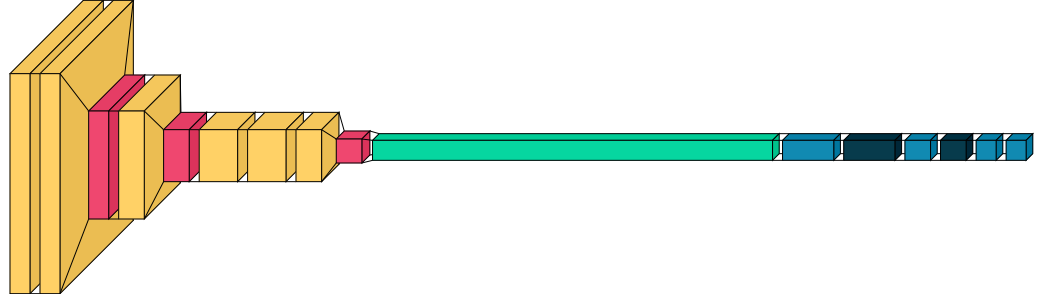

In [ ]:
# # Original Alexnet
#     # Start 227x227x3
#     model.add(Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
#     # -> 55x55x96
#     model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
#     # -> 27x27x96
#     model.add(Conv2D(256, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"))
#     # -> 27x27x256 

    # model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
    # # -> 13x13x256
    # model.add(Conv2D(384, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"))
    # # -> 13x13x384
    # model.add(Conv2D(384, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"))
    # # -> 13x13x384
    # model.add(Conv2D(256, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"))
    # # -> 13x13x256
    # model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
    # # -> 6x6x256
    # model.add(Flatten())



def create_cnn(NUM_CLASSES, WEIGHTS_PATH):
    """ 
    This Function builds and compiles CNN model using keras.

    ARGS:
    - num_classes: Number of classes in the dataset
    - weights_path: Path to the weights of the model (transfer learning)

    RETURNS:
    - model: Compiled keras modeL
    """
    
    # initialize the model
    model = Sequential()

    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(Conv2D(96, kernel_size=(11, 11), dilation_rate=(4, 4), activation='relu', padding="same"))
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

    model.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))
    model.add(Conv2D(384, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
    model.add(Conv2D(384, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
    model.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # TODO: COMMENT THIS
        metrics=['accuracy']
    )

    # if WEIGHTS_PATH.exists():
    #     model.load_weights(WEIGHTS_PATH)
    
    model.add(Dense(5, activation='softmax'))

    model.compile(
        optimizer= Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    model.summary()

    return model

model = create_cnn(NUM_CLASSES, WEIGHTS_PATH)
visualkeras.layered_view(model)





In [ ]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used for training.")
else:
    print("No GPU detected. Training will be done on CPU, THIS WILL SUCK!")


No GPU detected. Training will be done on CPU, THIS WILL SUCK!


In [ ]:
# stopping = EarlyStopping(monitor="accuracy") # Comment and do this more advanced later

AUTOTUNE = tf.data.experimental.AUTOTUNE #  optimize the data loading

norm_train_split = norm_train_split.cache().prefetch(buffer_size=AUTOTUNE)
norm_val_split = norm_val_split.cache().prefetch(buffer_size=AUTOTUNE)

model.fit(
    norm_train_split,
    epochs=NUM_EPOCHS,
    validation_data=norm_val_split,
    # callbacks=[stopping],
)

model.save_weights("model.h5")
# Saving only the weights in the folder
model.save_weights("weights.h5")

# saving architecture, to json
json_string = model.to_json()

with open("nn_architecture", "w") as f:
    f.write(json_string)

Epoch 1/80


26/26 [==============================] - 821s 31s/step - loss: 1.6286 - accuracy: 0.2223 - val_loss: 1.5986 - val_accuracy: 0.2477
Epoch 2/80
26/26 [==============================] - 811s 31s/step - loss: 1.6064 - accuracy: 0.2451 - val_loss: 1.5966 - val_accuracy: 0.2477
Epoch 3/80
26/26 [==============================] - 805s 31s/step - loss: 1.6009 - accuracy: 0.2503 - val_loss: 1.5958 - val_accuracy: 0.2477
Epoch 4/80
26/26 [==============================] - 806s 31s/step - loss: 1.6010 - accuracy: 0.2497 - val_loss: 1.5962 - val_accuracy: 0.2477
Epoch 5/80
26/26 [==============================] - 800s 31s/step - loss: 1.6010 - accuracy: 0.2497 - val_loss: 1.5961 - val_accuracy: 0.2477
Epoch 6/80
26/26 [==============================] - 795s 31s/step - loss: 1.6012 - accuracy: 0.2500 - val_loss: 1.5962 - val_accuracy: 0.2477
Epoch 7/80
26/26 [==============================] - 793s 31s/step - loss: 1.6055 - accuracy: 0.2438 - val_loss: 1.5965 - val_accuracy: 0.2477
Epoch 8/80
26/26 

In [ ]:
metrics = pd.DataFrame(model.history.history)
# metrics.to_csv("metrics.csv", index=False)
metrics.head()

NameError: name 'model' is not defined

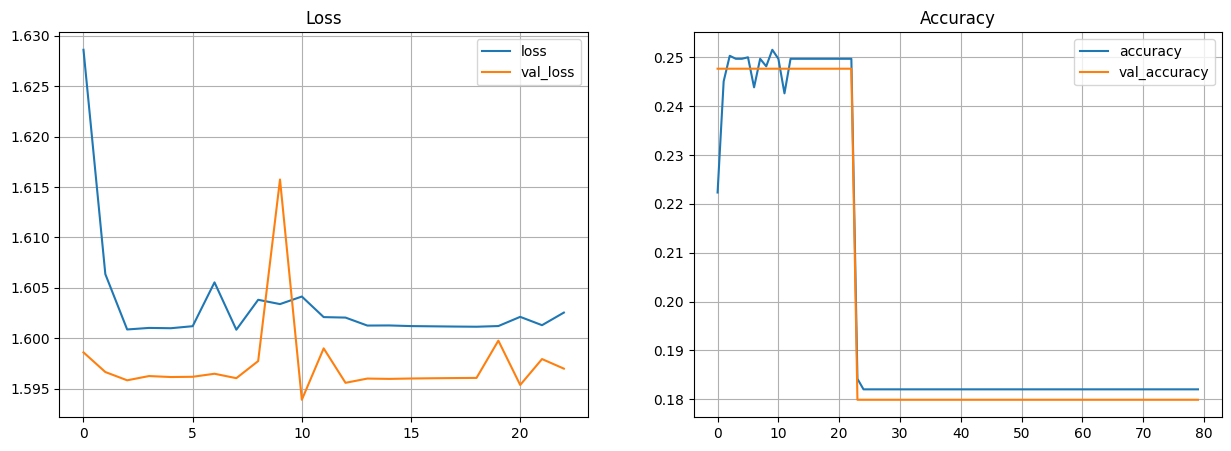

In [ ]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    metrics[['loss', 'val_loss']].plot(ax=ax[0], title= 'Loss', grid=True)
    metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title= 'Accuracy', grid=True) 

plot_metrics(metrics)

In [ ]:

# ## THIS IS WITH COMMENTS 
# def ConvCNN(NUM_CLASSES, WEIGHTS_PATH):
#     """ Inputs for the model 
#     - num_classes: Number of classes in the dataset
#     - weights_path: Path to the weights of the model (transfer learning)
#     """
    
#     # initialize the model
#     model = Sequential()
    
#     # 1st and 2nd layer(dilated but the same size as first layer)
#         # start 227x227x3
#     model.add(Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
#         # Out -> 55x55x96
#     model.add(Conv2D(96, kernel_size=(11, 11), dilation_rate=(4, 4), activation='relu', padding="same"))
#         # In 55x55x96 -> Out 55x55x96 (dilated for crude general shapes early in the network without losing spatial dimensions and significant compute)
#     # ------------- Down Sizing image by 2 ----------------
#     model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
#         # Out -> 27x27x96
#     # 3rd layer
#     model.add(Conv2D(256, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"))
#         # In 27x27x96 -> Out 27x27x256
    
#     # ----------- Down Sizing image by 2 ------------------
#     model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
#         # Out -> 13x13x256
#     # 4th layer
#     model.add(Conv2D(384, kernel_size=(5, 5), dilation_rate=(2, 2), activation='relu', padding="same"))
#         # In 13x13x256 ->  Out 13x13x384
#     # 5th layer
#     model.add(Conv2D(384, kernel_size=(5, 5), dilation_rate=(2, 2), activation='relu', padding="same"))
#         # In 13x13x384 -> Out 13x13x384
#     # 6th layer
#     model.add(Conv2D(256, kernel_size=(5, 5), dilation_rate=(2, 2), activation='relu', padding="same"))
#         # In 13x13x384 Out 13x13x256

#     # ----------- Down Sizing image by 2 ------------------
#     model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
#         # Out -> 6x6x256
    
#     model.add(Flatten())
#         # In 6x6x256 -> Out 1D array with 9216 elements


#     # Dense Layer 1
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5)) # for regularization, this drops 50% of the neurons and reduced overfitting
#         # Out -> 1D array with 512 elements and after 50% dropout = 256 neurons

#     # Dense Layer 2
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5)) # for regularization, this drops 50% of the neurons and reduced overfitting
#         # Out -> 1D array with 512 neurons and after 50% dropout = 256 neurons

#     # Dense Layer 3
#     model.add(Dense(NUM_CLASSES, activation='softmax'))
#         # Out -> 1D array with 5 neurons (5 classes)


#     # Total Expected parameters is 15.275.493

#     model.compile(
#         optimizer='adam',
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # TODO: COMMENT THIS
#         metrics=['accuracy']
#     )
    
#     model.add(Dense(5, activation='softmax'))
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     model.summary()



# ----------------------------
# # Original Alexnet
#     # Start 227x227x3
#     model.add(Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
#     # -> 55x55x96
#     model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
#     # -> 27x27x96
#     model.add(Conv2D(256, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"))
#     # -> 27x27x256 

    # model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
    # # -> 13x13x256
    # model.add(Conv2D(384, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"))
    # # -> 13x13x384
    # model.add(Conv2D(384, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"))
    # # -> 13x13x384
    # model.add(Conv2D(256, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"))
    # # -> 13x13x256
    # model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
    # # -> 6x6x256
    # model.add(Flatten())


    # model.add(Dense(4096, activation='relu'))
    # model.add(Dropout(0.5)) # for regularization, this drops 50% of the neurons

    # model.add(Dense(4096, activation='relu'))
    # model.add(Dropout(0.5)) # for regularization, this drops 50% of the neurons
# --------------------------------------

In [ ]:
""" 
TODO: 

Step 1.5 Fix what type of data will be in the splits.. (This is just classes so it should be categorical perhaps?) 

Step 2. Neural network construction with the layers
    - Alexnet is trained for a lot of classes but we only need to use it for 5 classes (5 neurons in the last layer(?)) 
    - This would mean we could optimize the model by cutting of some layers or something
Step 3. Compile the model (optimizer, loss function, metrics)
Step 4. Train the model (model.fit())
    - Investigate early stopping and double descent(?)
    - Have metrics that track the val loss and training accuracy during training (Would be nice to have it visually)
Step 5. Save the model (model.save()) (save the model and the weights)
Step 6. Make predictions (model.predict())
Step 7. Evaluate the model (model.evaluate()) (confusion matrix, accuracy etc)
Step 8. Visualize the results (plotting the results) (plotting the loss and accuracy)
"""

In [ ]:
""" This is the part of the code where model build is constructed and also trained. 
Will need to follow the workflow how to create it.

Step 1. Standardize the data (normalize the data) (divide by 255) (this is done in the model.fit() function) DONE


Step 1.5 Fix what type of data will be in the splits.. (This is just classes so it should be categorical perhaps?) 
Step 2. Neural network construction with the layers
    - Alexnet is trained for a lot of classes but we only need to use it for 5 classes (5 neurons in the last layer(?)) 
    - This would mean we could optimize the model by cutting of some layers or something
Step 3. Compile the model (optimizer, loss function, metrics)
Step 4. Train the model (model.fit())
    - Investigate early stopping and double descent(?)
    - Have metrics that track the val loss and training accuracy during training (Would be nice to have it visually)

    # TODO: Make the model run faster with prefetch caching??
    # TODO: Investigate tensorboard more if visualization fucks up. 
    # TODO: Overfitt model (e.g ) let it run its course without stopping
Step 5. Save the model (model.save()) (save the model and the weights)
Step 6. Make predictions (model.predict())
Step 7. Evaluate the model (model.evaluate()) (confusion matrix, accuracy etc)
Step 8. Visualize the results (plotting the results) (plotting the loss and accuracy)

"""






